In [ ]:
#Install adjusttext
!pip install adjustText

In [108]:
# 1.Import Libarys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# 2.Loading Dataset
spot_df = pd.read_csv("/home/user/file.csv")

In [110]:
# 3. Cleaning the Dataset
#Cleaning the Column-Names from Whitespaces
spot_df.columns = spot_df.columns.str.strip().str.lower()

#Drop non-numeric and unneeded columns
spot_df = spot_df.drop(columns=[
    "artist",
    "type",
    "duration_ms",
    "time_signature",
    "id",
    "html",
    "key",        # if you don’t want to include musical key
    "mode"        # if you don’t want to include mode
], errors="ignore")

#Select the audio features columns for scaling&clustering
features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]
X = spot_df[features]



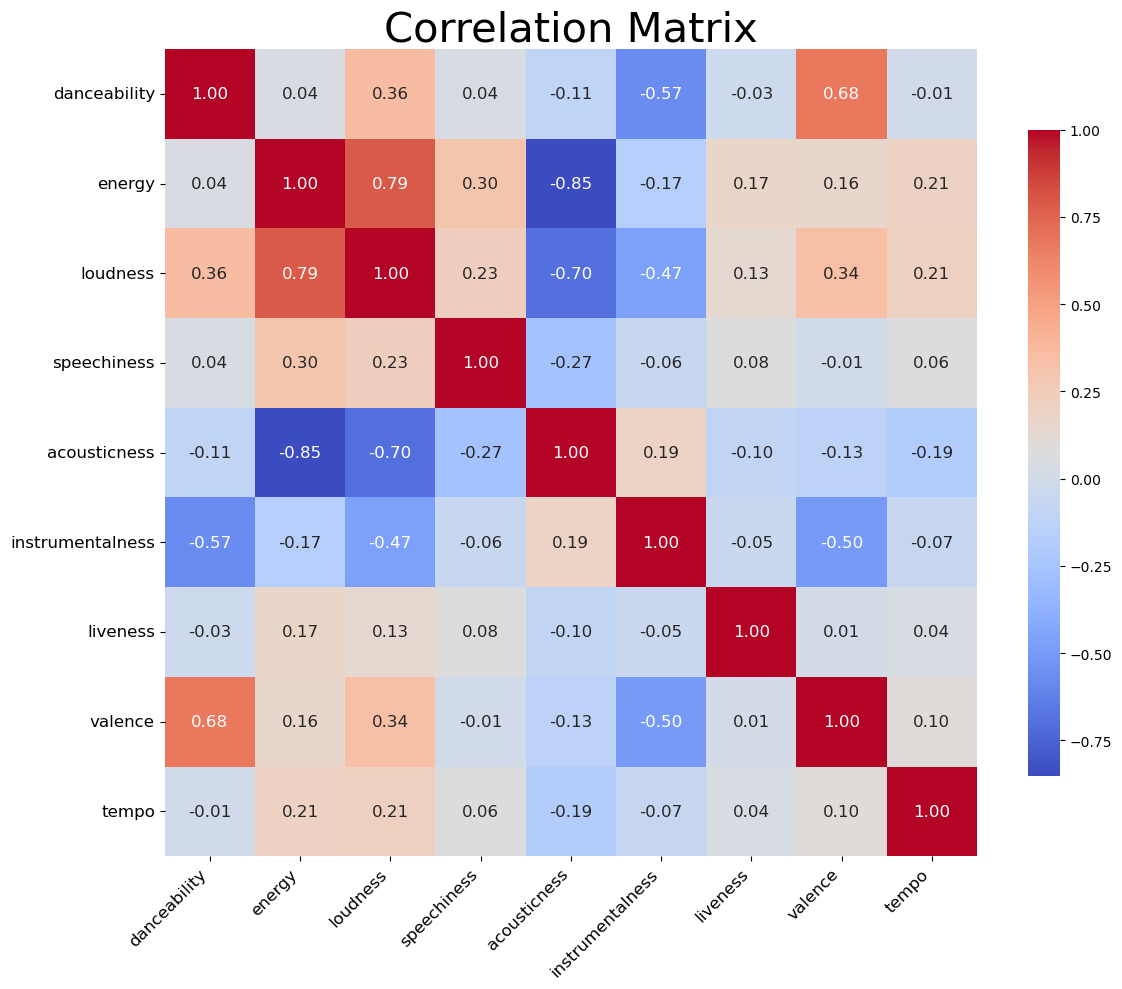

In [ ]:
#4. Correlation Matrix between the given Audio-Features in a Heatmap => Getting a first insight if the Logic of the Audio-Features is working

#Choosing only numeric features, filtered by float and int
numeric_features = X.select_dtypes(include=['float64', 'int64'])

#Correlationmatrix
corr_matrix = numeric_features.corr()

#Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 12},  # Schriftgröße für Werte im Raster
            cbar_kws={"shrink": 0.8})  # Farblegende etwas kleiner

#Changing Font Size 
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

#Title
plt.title("Correlation Matrix", fontsize=30)

plt.tight_layout()
plt.show()

In [112]:
#5. Use Playlist names for Cluster-Names:
cluster_labels = {
    0: "Classic Pop & Rock",
    1: "Hip-Hop & Pop-Rock Fusion",
    2: "Jazz & Neo-Classical Piano",
    3: "Extreme Death Metal",
    4: "Indie & World-Beat",
    5: "Old-School Death Metal",
    6: "Global Pop & MPB",
    7: "Classical Masters",
    8: "Country & Folk Rock Classics",
    9: "Latin Pop & Reggaeton",
    10: "Electronic & Gospel",
    11: "Vintage Jazz & R&B",
    12: "Deep House & Techno",
    13: "Contemporary Classical & Ambient",
    14: "Urban Pop & Soft Rock",
    15: "Electronic & Hip-Hop Fusion",
    16: "Melodic Death Metal",
    17: "Electro House & Dance",
    18: "Raw Death Metal",
    19: "90s Death Metal",
    20: "Baroque & Jazz Classics",
    21: "Hardstyle",
    22: "Jazz Legends & Piano Masterpieces",
    23: "Vintage Pop & Chanson",
    24: "Dream Pop & Indie"
}

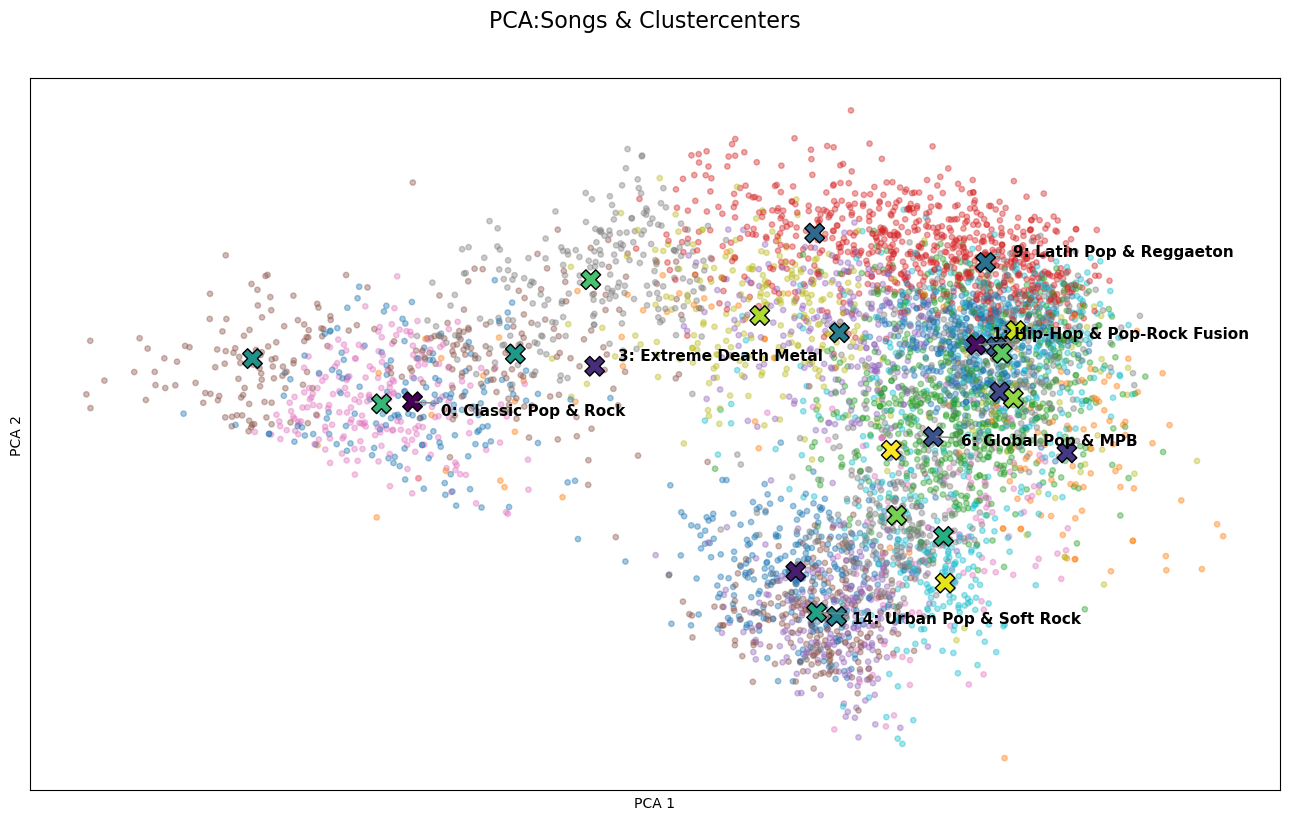

In [ ]:
#6. SCATTERPLOT
#6.1 Select 6/25 clusters to label in the plot
selected_cluster_indices = [0, 1, 3, 6, 9, 14]

#6.2 Scaling
X = spot_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#6.3 KMeans
k = 25 #Total Number of Clusters
kmeans = KMeans(n_clusters=k, random_state=42)
spot_df['cluster'] = kmeans.fit_predict(X_scaled)

#6.4 Principal Component Analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)


#6.5 Visualization Scatterplot
plt.figure(figsize=(13, 8))

#6.6 Songs as Dots in the Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=spot_df['cluster'], cmap='tab10', alpha=0.4, s=15, label='Songs')

#6.7 Visualizing Centroids 
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c=range(k), marker='X', s=200, edgecolor='black', label='Cluster-centers')

#6.8 Label selected clusters by using the dictionary
texts = []
for i, (x, y) in enumerate(centroids_2d):
    if i in selected_cluster_indices:
        label_text =f"{i}: {cluster_labels[i]}"
        texts.append(plt.text(x, y, label_text, fontsize=11, fontweight='bold'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.suptitle("PCA:Songs & Clustercenters", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# 7.1 Using the X Audio Feature Dataframe
features = X.columns.tolist()
# 7.2 Means per Cluster
cluster_means = spot_df.groupby('cluster')[features].mean()

In [ ]:
# 8. Only selected Clusters
selected_cluster_indices = [0, 1, 3, 6, 9, 14]
selected_clusters = cluster_means.loc[selected_cluster_indices]

In [120]:
# 9. Scale values for comparable display in the radar plot
scaler = MinMaxScaler()
selected_clusters_scaled = pd.DataFrame(
    scaler.fit_transform(selected_clusters),
    columns=features,
    index=selected_clusters.index
)

In [ ]:
# 10. Using the Dictionary from above with a for-loop with the selected_clusters_indices
labels = [cluster_labels[i] for i in selected_cluster_indices]

In [124]:
# 11. RADARPLOT

def plot_radar(cluster_data, labels=None, title="Cluster Profile"):
    categories = list(cluster_data.columns)
    num_vars = len(categories)

    # Winkel für jedes Feature im Kreis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Kreis schließen

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for idx, row in cluster_data.iterrows():
        values = row.tolist() + [row.iloc[0]]
        label = labels[cluster_data.index.get_loc(idx)] if labels else cluster_data.index[idx] # Verwende den Index als Label
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.1)


    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=11)
    ax.set_ylim(0, 1)

    plt.title(title, size=18, pad=50)
    plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.8))
    plt.tight_layout()
    plt.show()

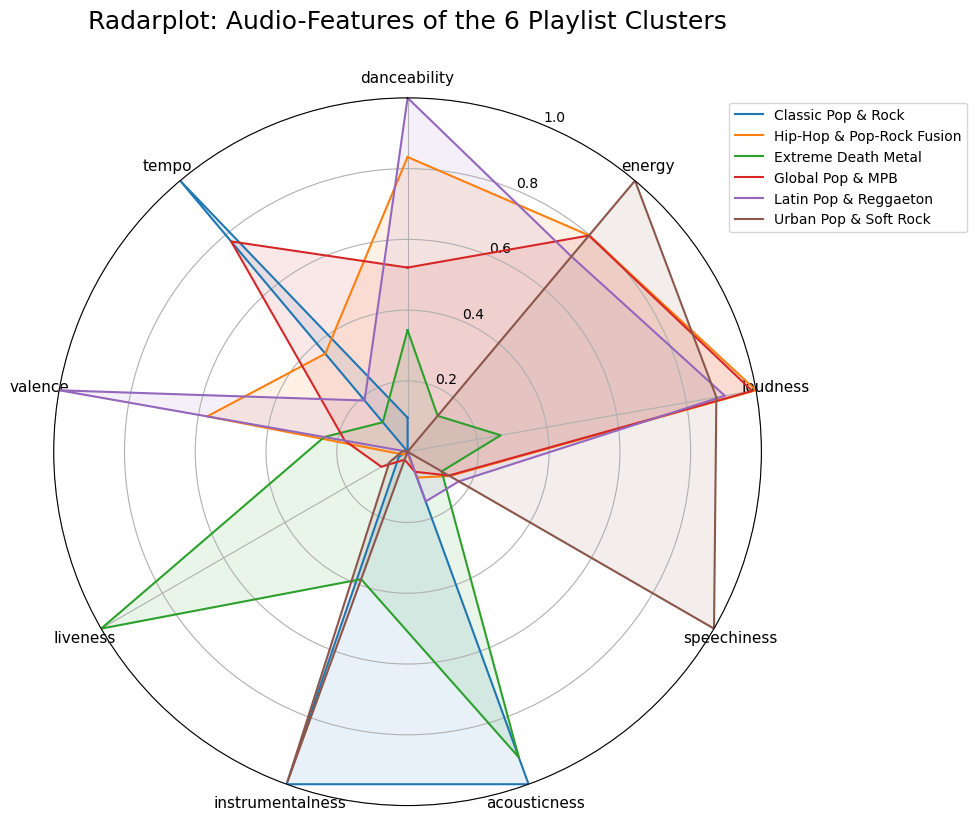

In [125]:
# 12. Show Radarplot
plot_radar(selected_clusters_scaled, labels=labels,
           title="Radarplot: Audio-Features of the 6 Playlist Clusters")
